Querying ? (RA=192.492269, Dec=5.315213)...
✅ Saved plot to: ?_spectrum_labeled.png


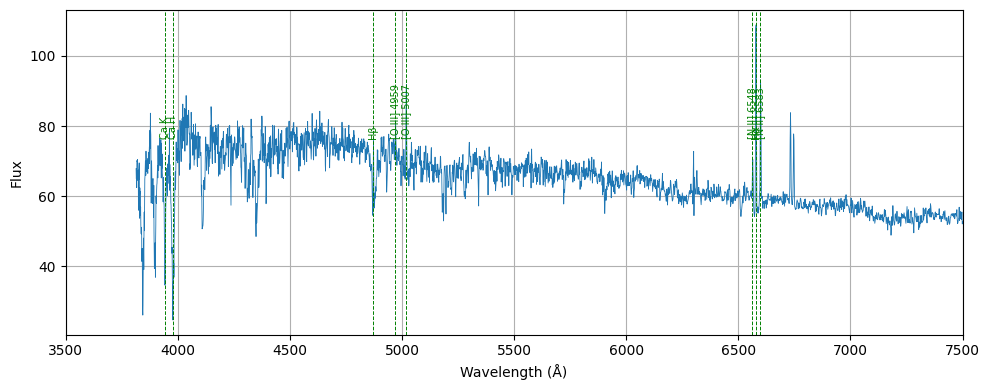

Querying ? (RA=112.745396655298, Dec=41.1665903074992)...
✅ Saved plot to: ?_spectrum_labeled.png


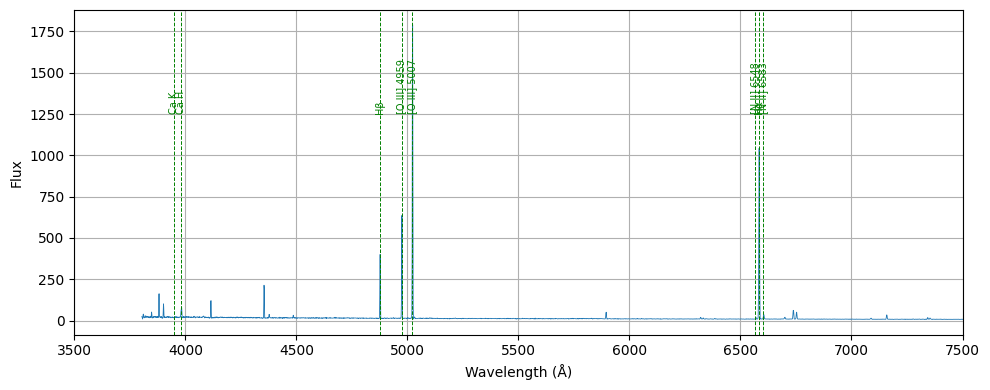

Querying ? (RA=195.903038094015, Dec=24.5255362362895)...
✅ Saved plot to: ?_spectrum_labeled.png


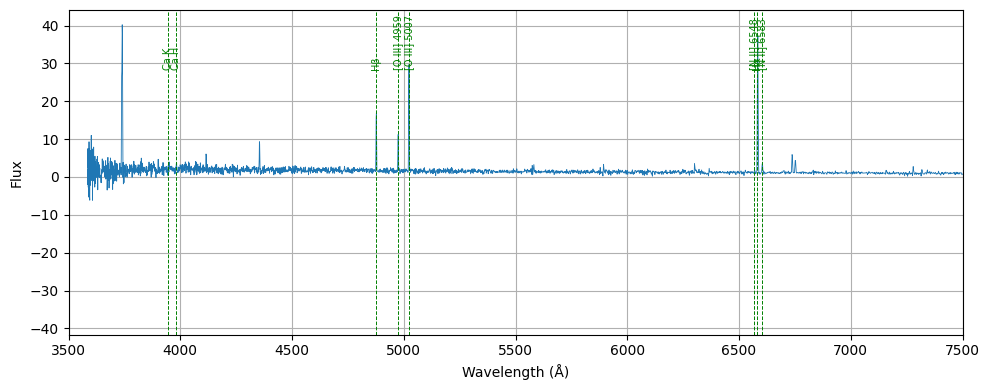

Querying ? (RA=184.233361965451, Dec=13.6254132150995)...
✅ Saved plot to: ?_spectrum_labeled.png


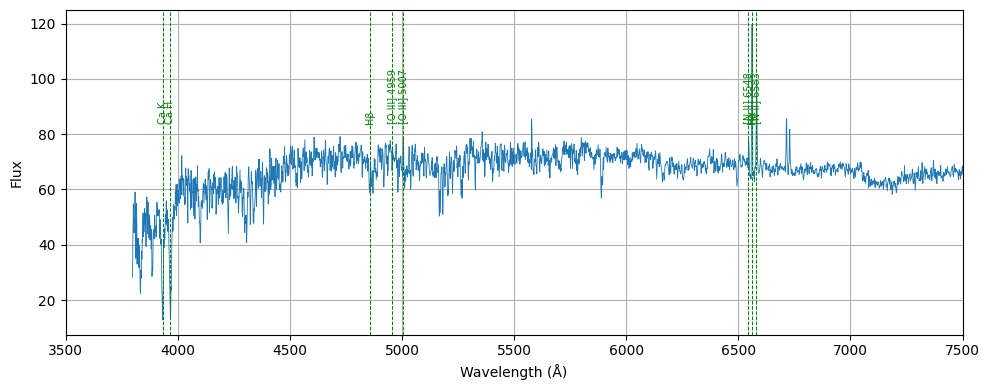

Querying NGC 7609 (RA=349.87521, Dec=9.50822)...
✅ Saved plot to: ngc_7609_spectrum_labeled.png


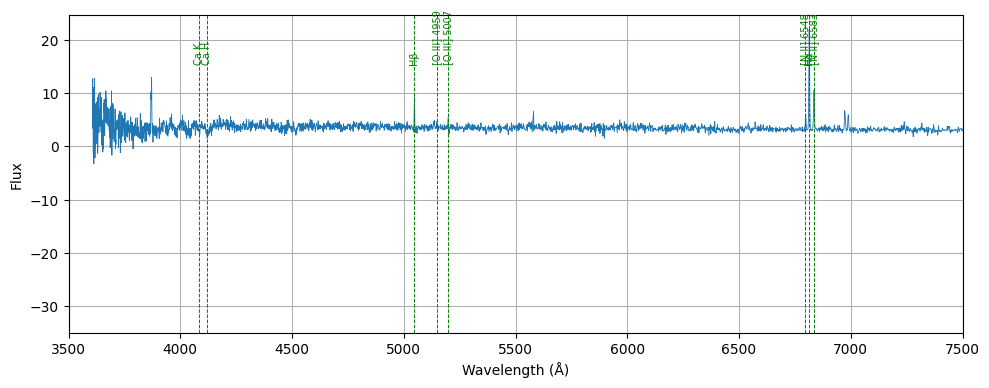

Querying SHOC 579 (RA=263.75521, Dec=57.0525)...
✅ Saved plot to: shoc_579_spectrum_labeled.png


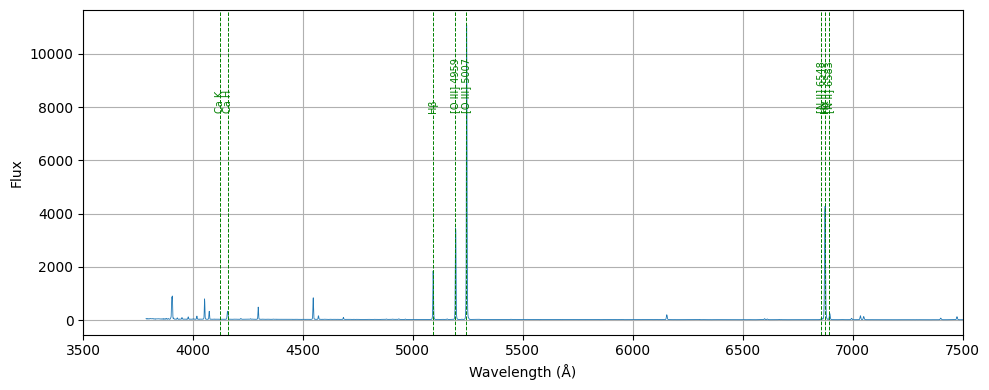

Querying SDSS J135646.10+102609.0 (RA=209.19208, Dec=10.43583)...
✅ Saved plot to: sdss_j135646.10+102609.0_spectrum_labeled.png


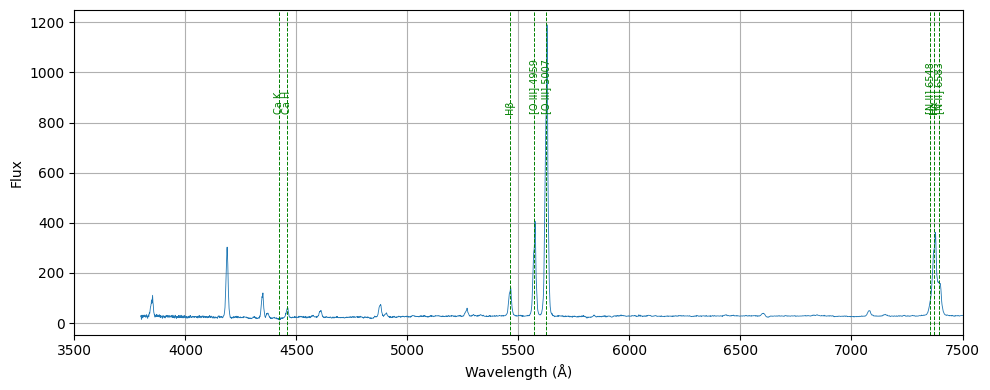

In [1]:
from astroquery.sdss import SDSS

from astroquery.simbad import Simbad

from astropy.coordinates import SkyCoord

import astropy.units as u

import matplotlib.pyplot as plt

import numpy as np



# Let's collect some galaxies in an array to loop over!

galaxies = [



    # Param's galaxy

    # RA = 192.492269  # Right Ascension (in degrees)

    # DEC = 5.315213   # Declination (in degrees)

    {"name": "?", "ra": 192.492269, "dec": 5.315213},



    # 112.745396655298	41.1665903074992

    {"name": "?", "ra": 112.745396655298, "dec": 41.1665903074992},

    

    # 195.903038094015	24.5255362362895

    {"name": "?", "ra": 195.903038094015, "dec": 24.5255362362895},



    # 184.233361965451	13.6254132150995

    {"name": "?", "ra": 184.233361965451, "dec": 13.6254132150995},



    # Galaxy: NGC 7609 — Interacting elliptical, strong Hα + [N II] emission

    {"name": "NGC 7609", "ra": 349.87521, "dec": 9.50822},



    # Galaxy: 

    {"name": "SHOC 579", "ra": 263.75521, "dec": 57.05250},



    # Galaxy: SDSS J135646.10+102609.0 — 

    {"name": "SDSS J135646.10+102609.0", "ra": 209.19208, "dec": 10.43583},

]

SEARCH_RADIUS = 0.01



# -----------------------------

# Common spectral lines (in Ångströms)

# -----------------------------

spectral_lines = {

    "Ca K": 3934.78,

    "Ca H": 3969.59,

    "Hβ": 4861.33,

    "[O III] 4959": 4958.91,

    "[O III] 5007": 5006.84,

    "[N II] 6548": 6548.05,

    "Hα": 6562.80,

    "[N II] 6583": 6583.45,

}



# -----------------------------

# If SIMBAD has a label for this galaxy, use it

# -----------------------------

def get_object_name(ra, dec):

    pos = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')

    try:

        result = Simbad.query_region(pos, radius='5s')

        if result is not None and len(result) > 0:

            return result[0]['MAIN_ID'].decode('utf-8').replace(' ', '_')

    except Exception:

        pass

    return None



# -----------------------------

# Main loop

# -----------------------------

for i, g in enumerate(galaxies):

    print(f"Querying {g['name']} (RA={g['ra']}, Dec={g['dec']})...")

    pos = SkyCoord(ra=g['ra']*u.deg, dec=g['dec']*u.deg)

    results = SDSS.query_region(

        pos,

        radius=SEARCH_RADIUS*u.deg,

        spectro=True,

        specobj_fields=['plate', 'mjd', 'fiberID', 'z']

    )



    if results is None or len(results) == 0:

        print(f"No spectra found for {g['name']}")

        continue



    # Use the first match

    row = results[0]

    try:

        spectrum = SDSS.get_spectra(plate=int(row['plate']),

                                    mjd=int(row['mjd']),

                                    fiberID=int(row['fiberID']))[0]

        hdu = spectrum[1]

        flux = hdu.data['flux']

        loglam = hdu.data['loglam']

        wavelength = 10**loglam



        z = float(row['z'])

        name = get_object_name(g['ra'], g['dec']) or g['name']

        safe_name = name.lower().replace(' ', '_')



        # Plot this spectra!

        plt.figure(figsize=(10, 4))

        plt.plot(wavelength, flux, lw=0.6)

        plt.xlim([3500, 7500])

        plt.xlabel("Wavelength (Å)")

        plt.ylabel("Flux")

        plt.grid(True)



        # Add vertical lines, based on the redshift

        for label, lam_rest in spectral_lines.items():

            lam_obs = lam_rest * (1 + z)

            if wavelength[0] < lam_obs < wavelength[-1]:

                plt.axvline(lam_obs, color='green', linestyle='--', linewidth=0.7)

                plt.text(lam_obs, max(flux)*0.7, label, rotation=90,

                         fontsize=7, color='green', ha='center', va='bottom')



        plt.tight_layout()

        filename = f"{safe_name}_spectrum_labeled.png"

        plt.savefig(filename, dpi=150)

        print(f"✅ Saved plot to: {filename}")

        plt.show()



    except Exception as e:

        print(f"Error retrieving or plotting {g['name']}: {e}")